In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [23]:
df = pd.read_csv("product_grade_rating.csv")

# Encode the grade into numeric class labels
grade_encoder = LabelEncoder()
df["grade_encoded"] = grade_encoder.fit_transform(df["grade"])

# Feature columns for prediction
feature_cols = [
    "price", "material_quality_score", "carbon_emission_score",
    "is_sustainable", "certifications_score", "packaging_score",
    "avg_rating", "review_sentiment_score", "rating_count"
]


In [24]:
X = df[feature_cols]
y = df["grade_encoded"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
print("\n=== Random Forest Classifier ===")

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=grade_encoder.classes_))



=== Random Forest Classifier ===
              precision    recall  f1-score   support

           A       0.65      0.58      0.62        48
          A+       0.85      0.88      0.87        33
           B       0.60      0.66      0.62        38
          B+       0.42      0.46      0.44        37
           C       0.90      0.84      0.87        44

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.69      0.68      0.68       200



In [26]:
print("\n=== Deep Learning Classifier ===")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encode targets
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
n_classes = y_train_cat.shape[1]

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



=== Deep Learning Classifier ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.fit(X_train_scaled, y_train_cat, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

y_pred_dl = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_dl, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=grade_encoder.classes_))


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2324 - loss: 1.6772 - val_accuracy: 0.3375 - val_loss: 1.5026
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3563 - loss: 1.4915 - val_accuracy: 0.5125 - val_loss: 1.3585
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4858 - loss: 1.3268 - val_accuracy: 0.5500 - val_loss: 1.1940
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5337 - loss: 1.1417 - val_accuracy: 0.6250 - val_loss: 1.0362
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6128 - loss: 1.0200 - val_accuracy: 0.7000 - val_loss: 0.8996
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6258 - loss: 0.8798 - val_accuracy: 0.7625 - val_loss: 0.7841
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7248 - loss: 0.7779 - val_accuracy: 0.7750 - val_loss: 0.7022
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7191 - loss: 0.7062 - val_accuracy: 0.8125 - val

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           A       0.94      0.96      0.95        48
          A+       0.94      1.00      0.97        33
           B       0.90      0.92      0.91        38
          B+       0.94      0.86      0.90        37
           C       0.98      0.95      0.97        44

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



In [28]:
def predict_grade(model_type="rf", features_dict={}):
    input_df = pd.DataFrame([features_dict])
    if model_type == "rf":
        return grade_encoder.inverse_transform(
            rf.predict(input_df)[0:1]
        )[0]
    elif model_type == "dl":
        scaled = scaler.transform(input_df)
        pred = model.predict(scaled)
        return grade_encoder.inverse_transform([np.argmax(pred)])[0]
    else:
        return "Invalid model type"


In [29]:
print("\nPredicting grade for a new product:")
example = {
    "price": 2300,
    "material_quality_score": 0.82,
    "carbon_emission_score": 0.30,
    "is_sustainable": 1,
    "certifications_score": 0.75,
    "packaging_score": 0.7,
    "avg_rating": 4.5,
    "review_sentiment_score": 0.6,
    "rating_count": 560
}
print("Random Forest Prediction:", predict_grade("rf", example))
print("Deep Learning Prediction:", predict_grade("dl", example))


Predicting grade for a new product:
Random Forest Prediction: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Deep Learning Prediction: A


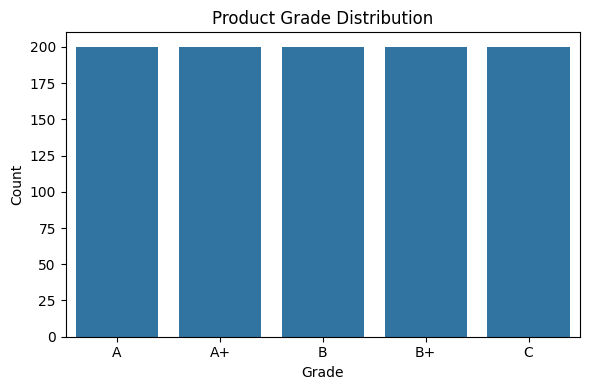

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(x='grade', data=df, order=sorted(df['grade'].unique()))
plt.title("Product Grade Distribution")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

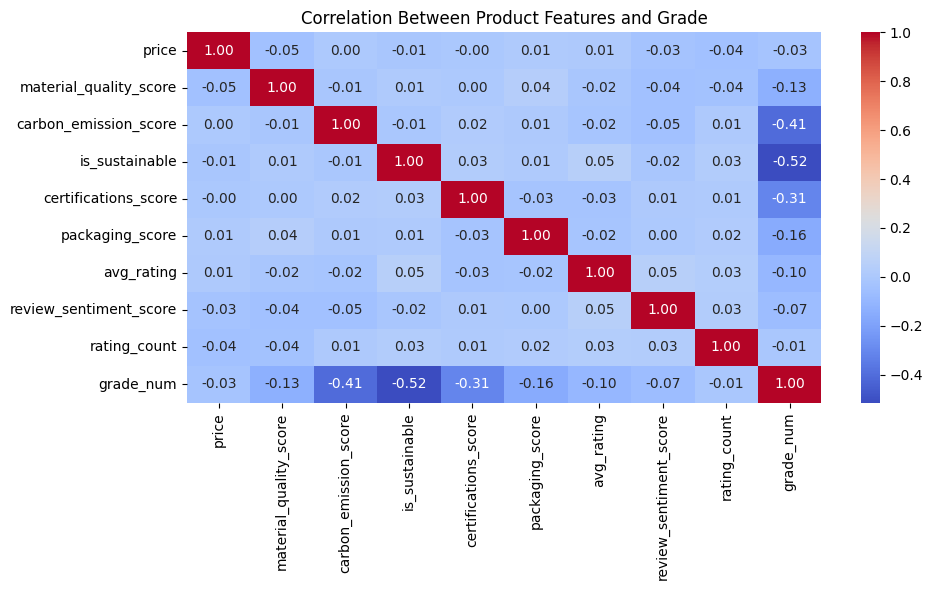

In [32]:
# Encode grade for heatmap
df['grade_num'] = grade_encoder.transform(df['grade'])

# Include grade in correlation
corr = df[feature_cols + ['grade_num']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Product Features and Grade")
plt.tight_layout()
plt.show()

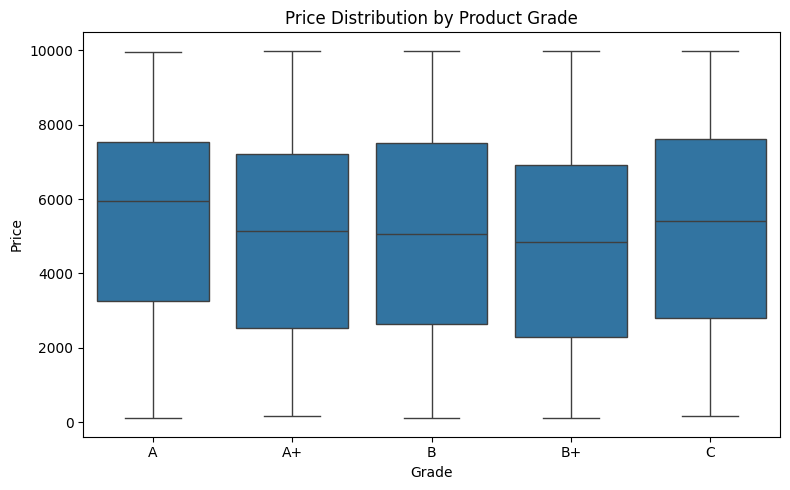

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='grade', y='price', order=sorted(df['grade'].unique()))
plt.title("Price Distribution by Product Grade")
plt.ylabel("Price")
plt.xlabel("Grade")
plt.tight_layout()
plt.show()

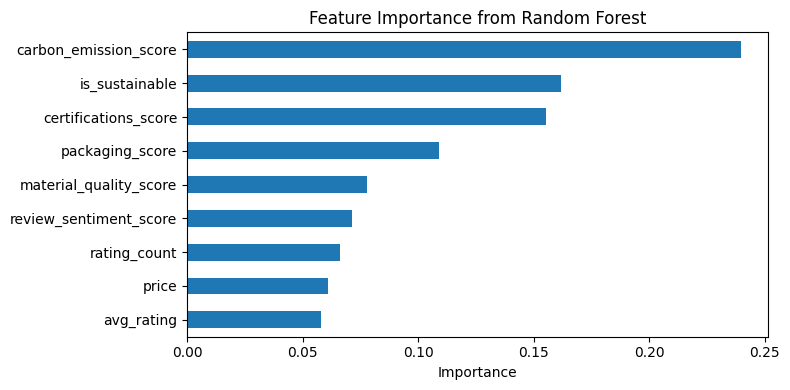

In [34]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values()

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='barh')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()